In [1]:
from PIL import Image
import os
import argparse
import numpy as np
import json
import csv
import rasterio
import matplotlib
import folium
from pyproj import Proj, transform


%matplotlib inline


Image.MAX_IMAGE_PIXELS = 100000000000

In [107]:
# ingest the image
infile = "../data/mosaics/SteepleJason_NTiptoGully_Nov2019_Reprocess_transparent_mosaic_group1.tif"

img_dir = '..' + infile.split(".")[2] + '_500x500_overlap60'
prj_name = img_dir.split("/")[-1]

In [108]:
infile

'../data/mosaics/SteepleJason_NTiptoGully_Nov2019_Reprocess_transparent_mosaic_group1.tif'

In [109]:
img_dir

'../data/mosaics/SteepleJason_NTiptoGully_Nov2019_Reprocess_transparent_mosaic_group1_250x250_overlap60'

In [110]:
prj_name

'SteepleJason_NTiptoGully_Nov2019_Reprocess_transparent_mosaic_group1_250x250_overlap60'

In [111]:
dataset = rasterio.open(infile)

In [112]:
# what is the name of this image
img_name = dataset.name
print('Image filename: {n}\n'.format(n=img_name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: ../data/mosaics/SteepleJason_NTiptoGully_Nov2019_Reprocess_transparent_mosaic_group1.tif

Number of bands in image: 4

Image size is: 83420 rows x 15247 columns

Raster description: (None, None, None, None)

Raster driver: GTiff

Image projection:
EPSG:32720 

Image geo-transform:
| 0.01, 0.00, 622506.63|
| 0.00,-0.01, 4347307.39|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 15247, 'height': 83420, 'count': 4, 'crs': CRS.from_epsg(32720), 'transform': Affine(0.012, 0.0, 622506.63289,
       0.0, -0.012, 4347307.39278)}




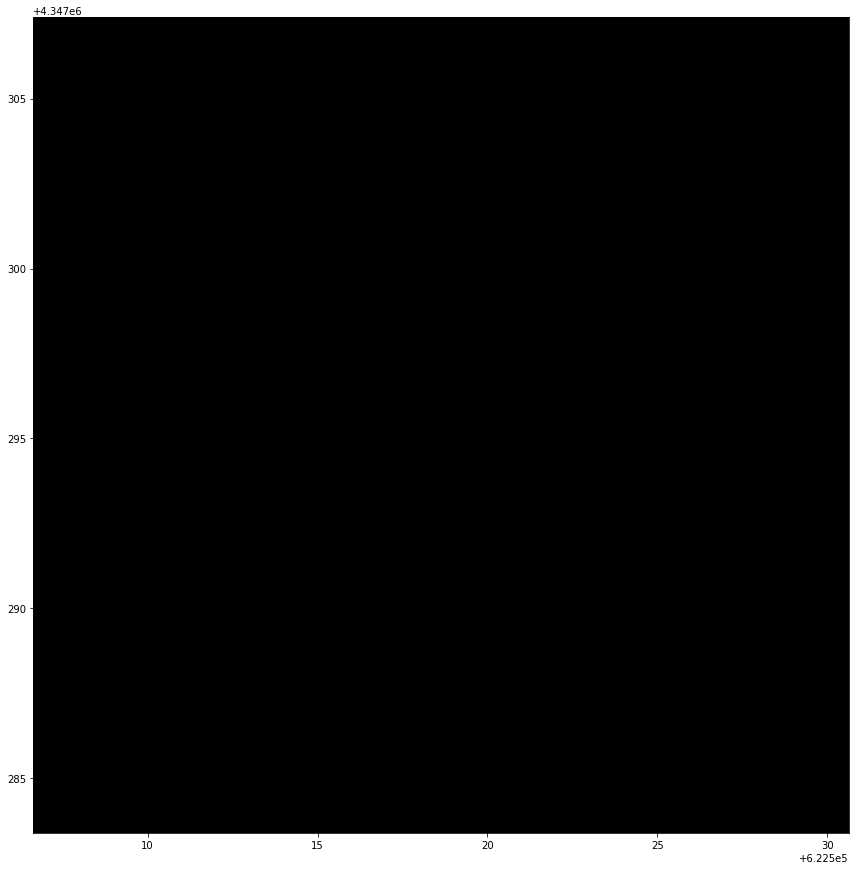

In [113]:
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))

show(dataset.read((1,2,3), window=Window(5000, 5000, 2000, 2000)), transform=dataset.transform, ax=ax)
plt.show()

In [114]:
from rasterio.windows import Window
with rasterio.open(infile) as src:
    w = src.read(1, window=Window(0, 0, 512, 256))

KeyboardInterrupt: 

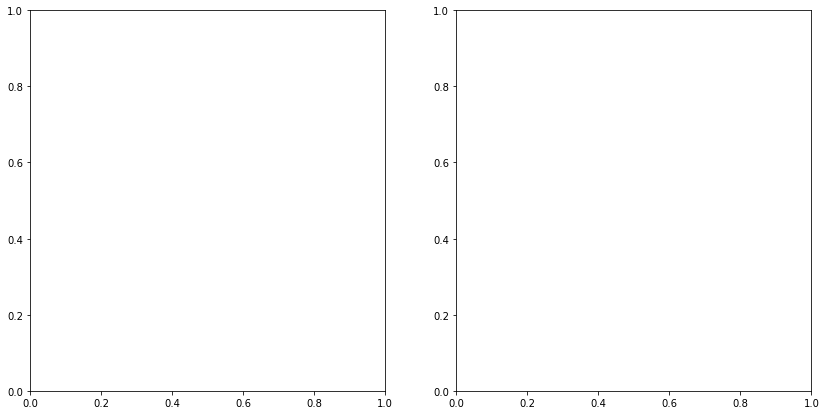

In [90]:
# plot the image with a histogram of band intensities

from rasterio.plot import show_hist

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
#show(dataset, ax=axrgb)
show(dataset.read(), transform=dataset.transform, ax=axrgb)
show_hist(dataset, bins=50, histtype='stepfilled', lw=0.0, stacked=False, alpha=0.3, ax=axhist)
plt.show()

In [115]:
dataset.crs

CRS.from_epsg(32720)

In [116]:
# Project all longitudes, latitudes
utm_tl = dataset.transform * (0, 0)
utm_br = dataset.transform * (dataset.width, dataset.height)
utm_center = dataset.transform * (dataset.width // 2, dataset.height // 2)

positions = dataset.transform * (0, 0), dataset.transform * (dataset.width, 0), dataset.transform * (dataset.width, dataset.height), dataset.transform * (0, dataset.height),

#longs, lats = transform(p1, p2, np.array(positions)[:,0],np.array(positions)[:,1])

p1 = Proj(dataset.crs)
p2 = Proj(proj='latlong',datum='WGS84')
tl_long, tl_lat = transform(p1, p2, utm_tl[0], utm_tl[1])
br_long, br_lat = transform(p1, p2, utm_br[0], utm_br[1])
center_long, center_lat = transform(p1, p2, utm_center[0], utm_center[1])
longs, lats = transform(p1, p2, np.array(positions)[:,0],np.array(positions)[:,1])

In [117]:
points = list(zip(lats, longs))

In [118]:
tl_long,tl_lat

(-61.25360095459688, -51.012736096835994)

In [119]:
m = folium.Map(location=[center_lat, center_long])

tooltip="Raster"
#folium.Marker([tl_lat, tl_long], popup='<i>Raster Top Left</i>', tooltip=tooltip).add_to(m)
#folium.Marker([br_lat, br_long], popup='<i>Raster Bottom right</i>', tooltip=tooltip).add_to(m)
#folium.Marker([center_lat, center_long], popup='<i>Raster Center</i>', tooltip=tooltip).add_to(m)

folium.Polygon(points, 
               tooltip=tooltip, 
               popup='Laurelhurst Park',
               color='#3186cc',
               fill=True,
               fill_color='#3186cc').add_to(m)

#folium.PolyLine(points, color="red", weight=100, opacity=1).add_to(m)

m

In [120]:
from rasterio.plot import reshape_as_image

# open TIFF file (reading) mode and get dimensions
dataset = rasterio.open(infile)
img_height, img_width = dataset.shape

# define tile size and number of pixels to move in each direction
tile_height = tile_width = 500
overlap = 60
stride = tile_height - overlap
start_num = 0
count = 0
img_dict = {}
# create the dir if it doesn't already exist
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

num_tiles = (img_width * img_height) / ((tile_height - overlap) * (tile_width - overlap))
print(dataset.shape)
print(num_tiles)

for r in range(0, img_height-tile_height+1, stride):
    for c in range(0, img_width-tile_width+1, stride):
        # read tile
        tile = dataset.read((1,2,3),window=Window(c, r, tile_width, tile_height))
        
        reshaped_tile = reshape_as_image(tile)
        
        top_pixel = [c,r]
        tile_name = prj_name + "---" + str(count) + ".png"
        img_dict[tile_name] = top_pixel
        
        im = Image.fromarray(reshaped_tile)
        
        
        path = os.path.join(img_dir, tile_name)
        im.save(path)
        
        count += 1

(83420, 15247)
35232.81828254848


In [121]:
full_dict = {"image_name" : infile,
            "image_locations" : img_dict,
             "crs" : str(dataset.crs)
            }

with open(img_dir + '/steeplejason_ntipgully_data_500x500_overlap60.json', 'w') as fp:
    json.dump(full_dict, fp)